<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Machine Learning Course</font></span>
        <span><br><font size=3>Spring 2022</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block> 
        <font size=5>Hands-On 7</font><br>
        <hr />
        <font size=3>Alireza Ghafouri</font><br>
        <font size=3><b><a href="mailto:alirezaghafouri@ut.ac.ir">alirezaghafouri@ut.ac.ir</a></b><br></font><br>

</div>

<hr>
<hr>
<hr>

# Expectation Maximization

In statistics, an expectation–maximization (EM) algorithm is an iterative method to find maximum likelihood or maximum a posteriori (MAP) estimates of parameters in statistical models, where the model depends on **unobserved latent variables**. The EM iteration alternates between performing:

**an expectation (E) step**, which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters, and 

**a maximization (M) step**, which computes parameters maximizing the expected log-likelihood found on the E step.

These parameter-estimates are then used to determine the distribution of the latent variables in the next E step.

## How the EM algorithm works

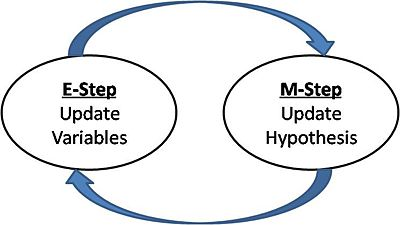

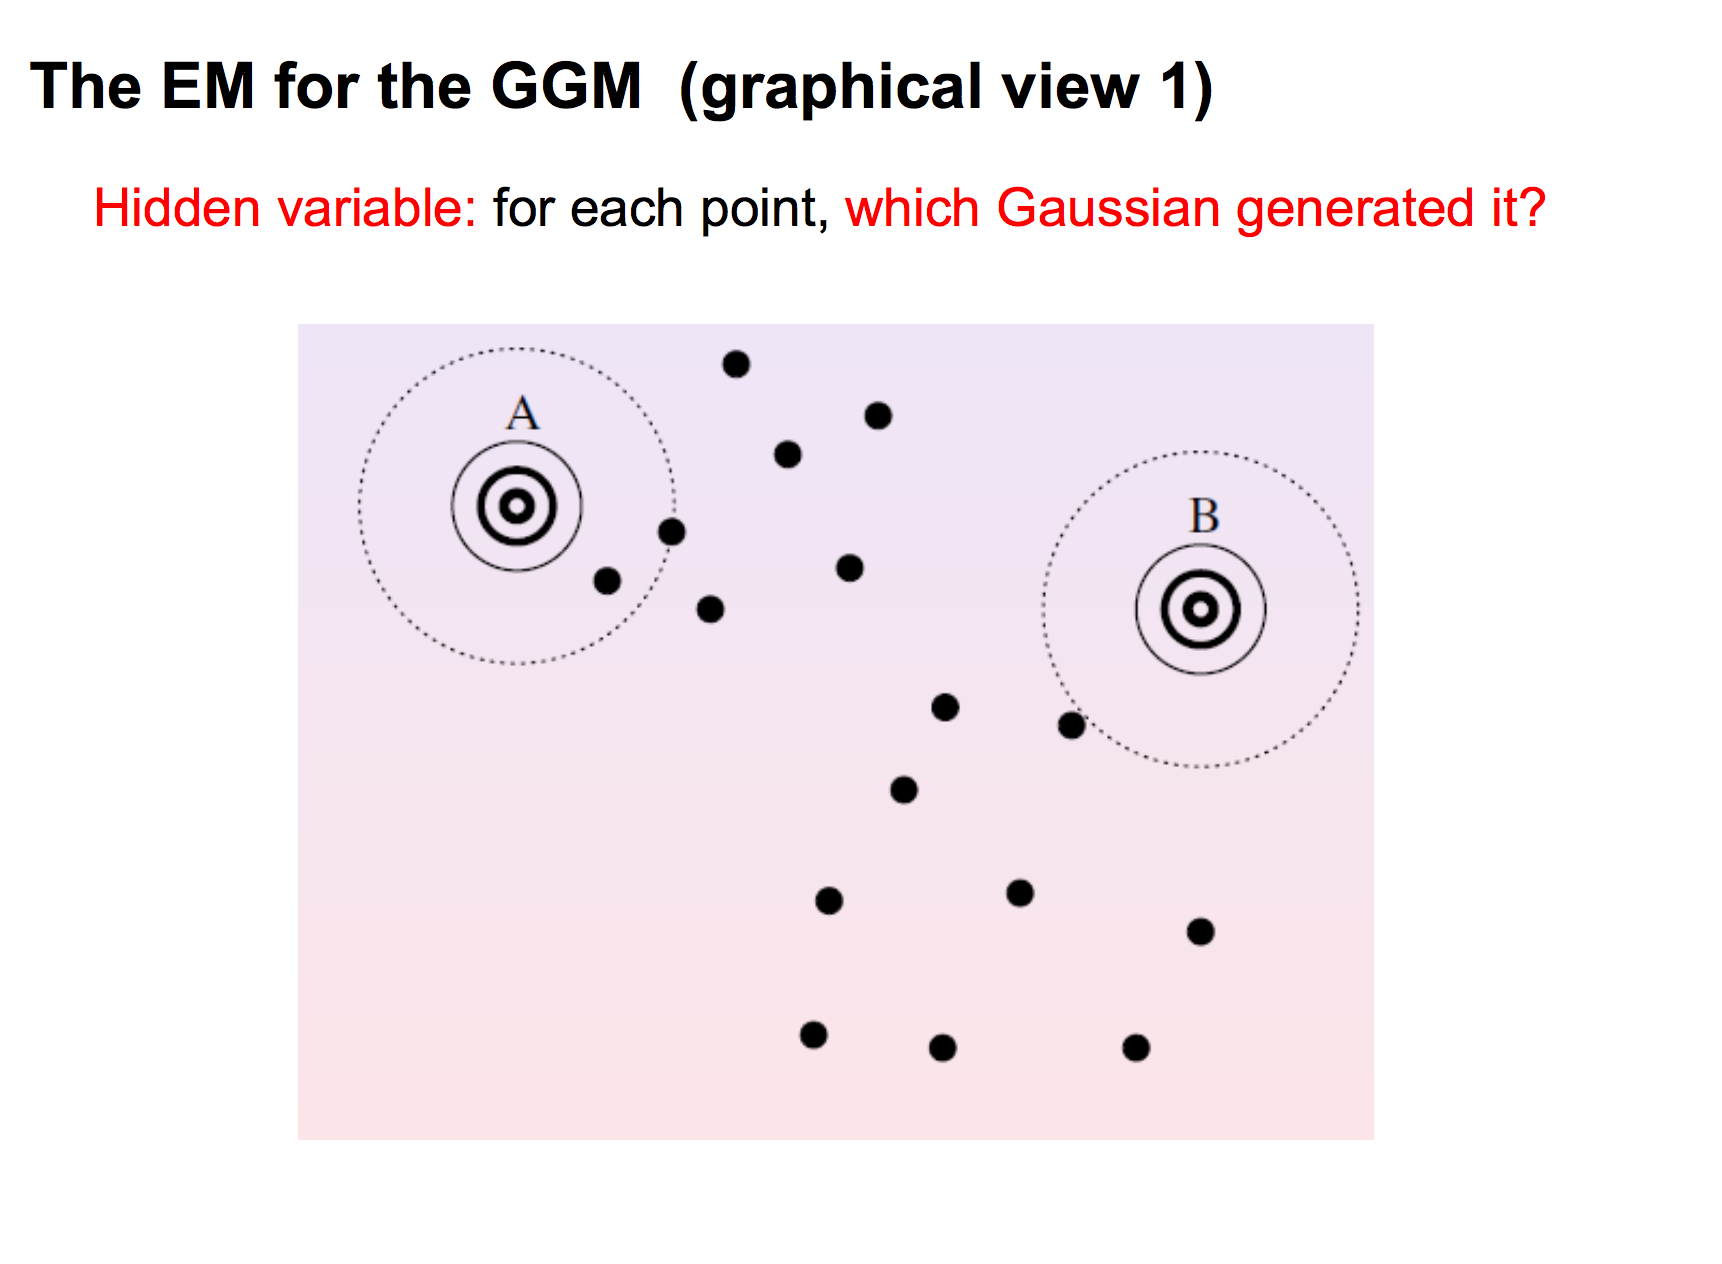

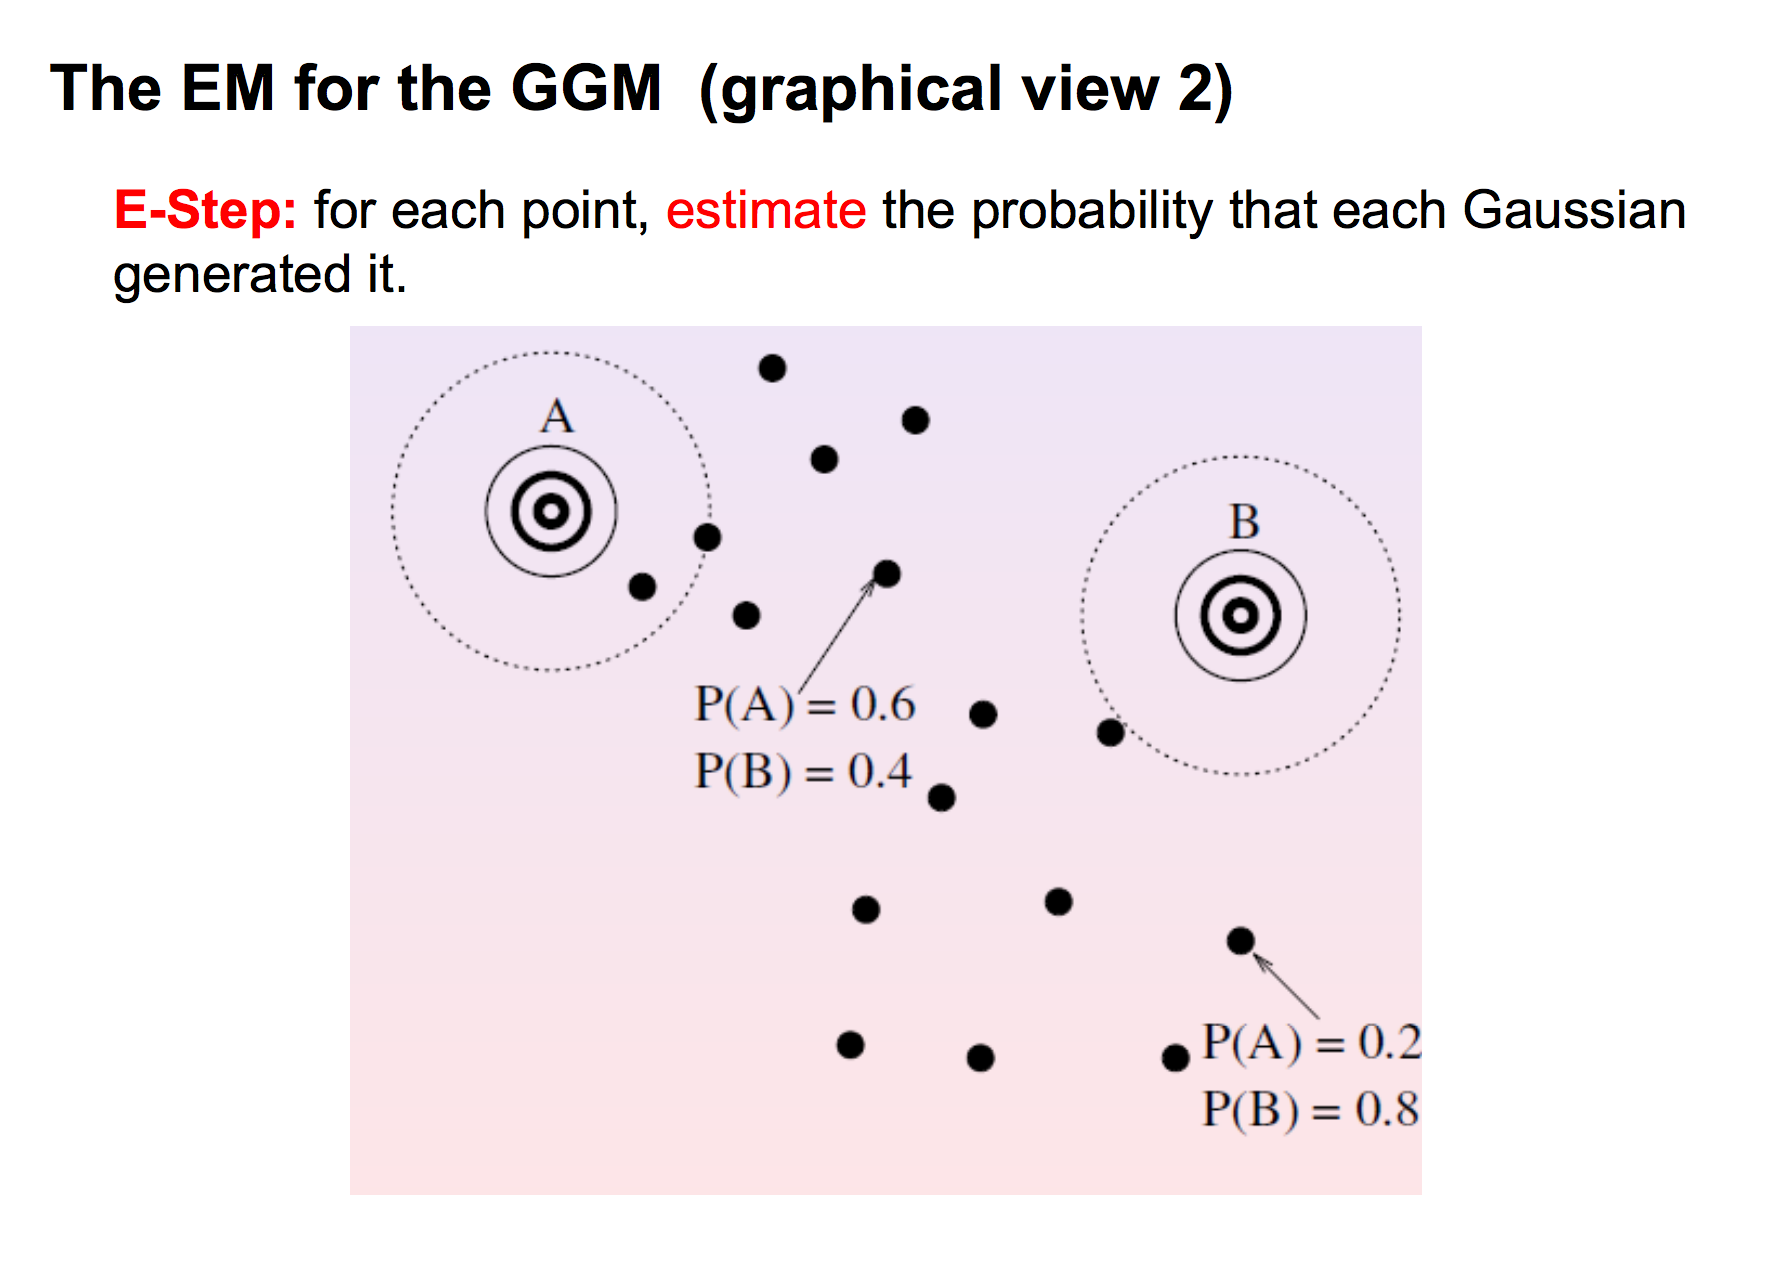

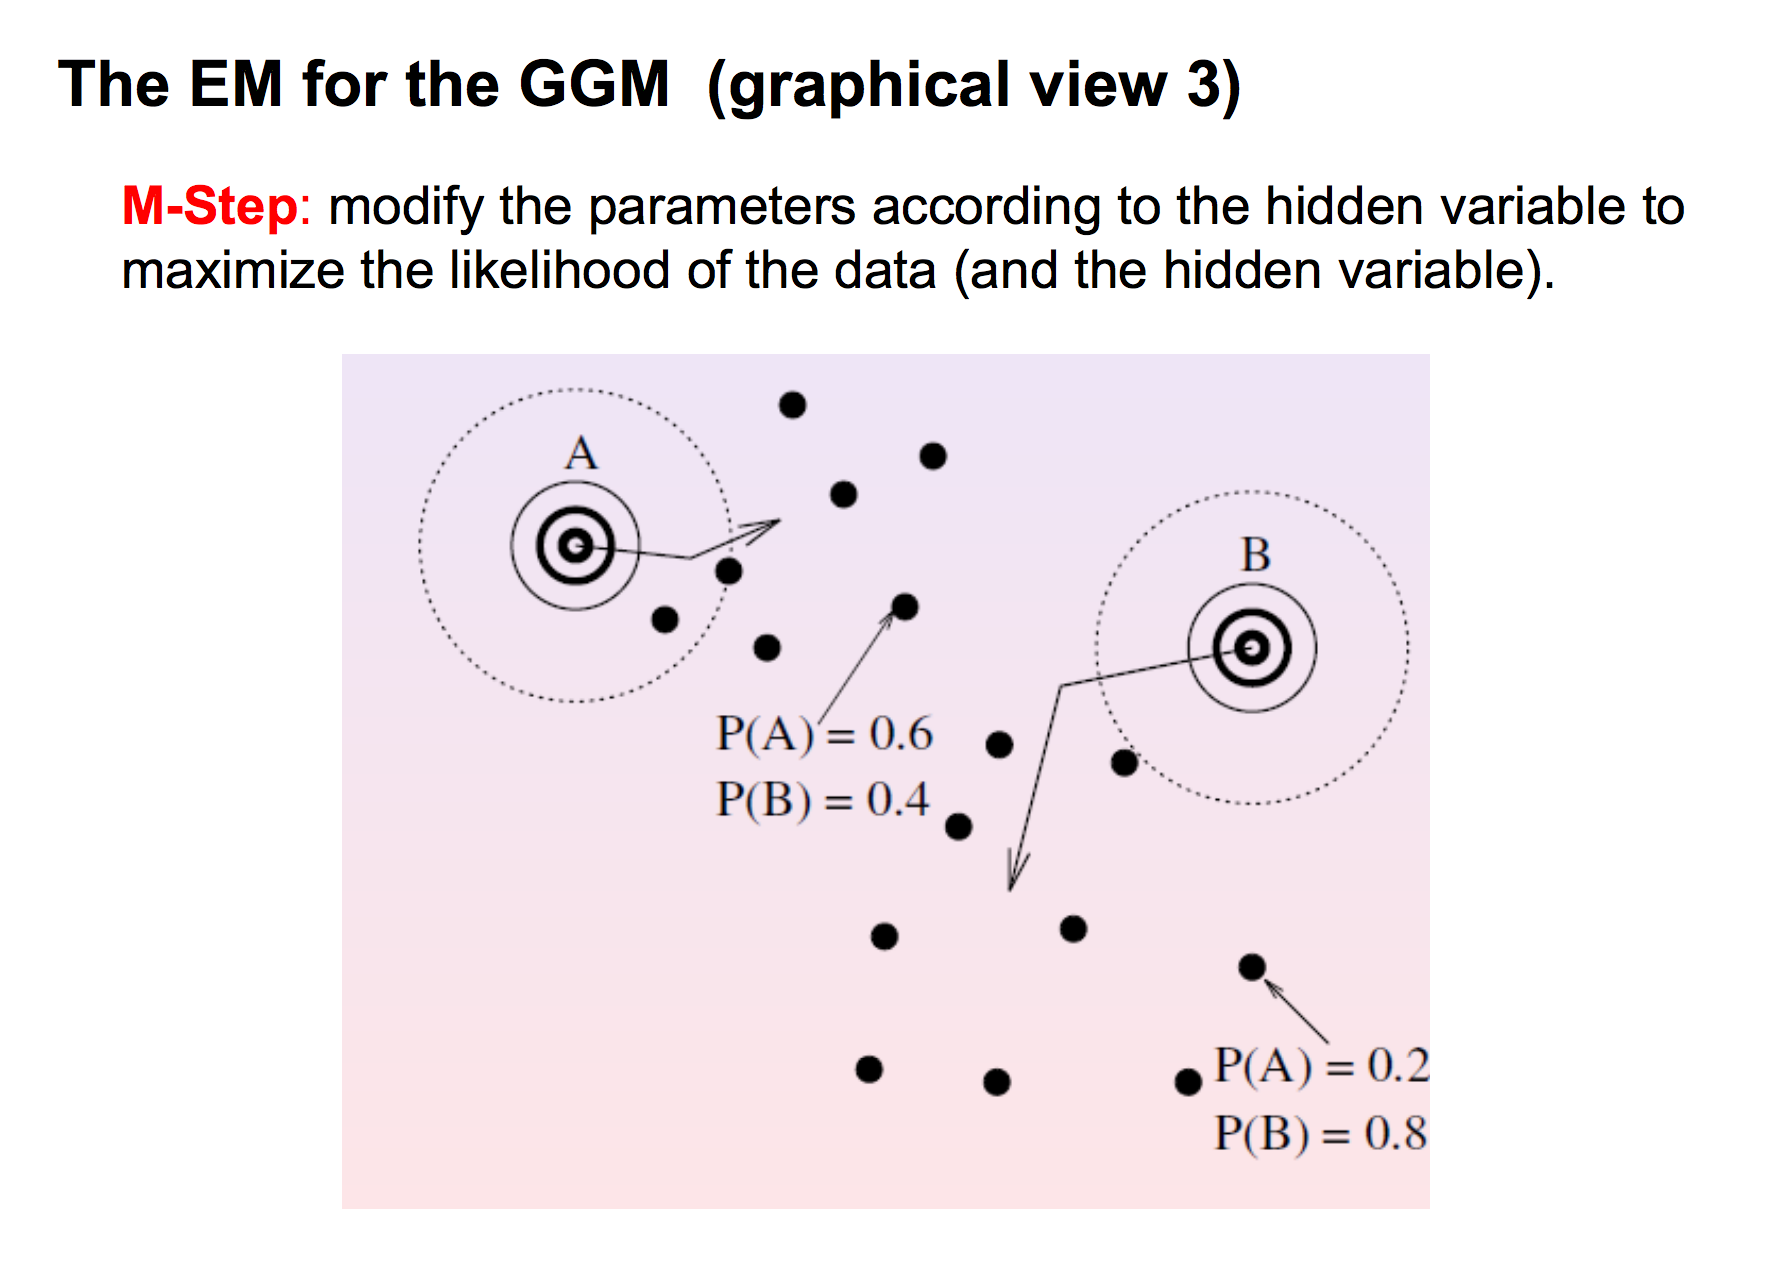

You can also have a look at this short video where it is explained very well on a 1-dimensional example: https://www.youtube.com/watch?v=iQoXFmbXRJA

## Basic example of Expectation Maximization

Let's try this on a simple basic example.

Objective: Let's etimate the probability distribution in a 1-dimensional dataset

**.** that we generated ourselves using 2 gaussian normal probability distributions.

**.** Using a Gaussian mixture model with 2 normal gaussian distributions

Or in other words, we should be able to find our own mean and standard deviation parameters we used to generate the testset.

Note, this notebook is for building the basic conceptual understanding of the EM algorithm. Not to have the best code, the best computable algorithm, etc. I tried to keep it simple.

# Gaussian Mixture Model of 2 Gaussians

Two Normal distributions $N(\mu_1, \sigma_1^2)$ and $N(\mu_2, \sigma_2^2)$ .

There are 5 paramaters to estimate: $\theta = (w, \mu_1, \sigma_1^2, \mu_2, \sigma_2^2)$  where  w  is the probability that the data comes from the first normal probability distribution (and 1- w ) it comes from the second normal probability distribution)

The probability density function (PDF) of the mixture model is: $$f(x | \theta) = w \  f_1(x \ | \  \mu_1, \sigma_1^2) + (1 - w) \  f_2 (x  \ | \  \mu_2, \sigma_2^2)$$
 
Objective is to best fit a given probability density by finding  $\theta = (w, \mu_1, \sigma_1^2, \mu_2, \sigma_2^2)$  through EM iterations

Let try it out

In [5]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline
#for matrix math
import numpy as np
#for normalization + probability density function computation
from scipy import stats
#for data preprocessing
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform
print("import done")

import done


Generate the data yourself Select $\mu_1, \sigma_1$  and  $\mu_2, \sigma_2$  to generate the data

Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0


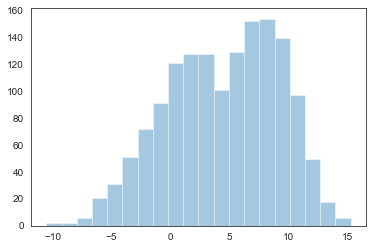

In [6]:
random_seed=36788765
np.random.seed(random_seed)

Mean1 = 2.0  # Input parameter, mean of first normal probability distribution
Standard_dev1 = 4.0 #@param {type:"number"}
Mean2 = 9.0 # Input parameter, mean of second normal  probability distribution
Standard_dev2 = 2.0 #@param {type:"number"}

# generate data
y1 = np.random.normal(Mean1, Standard_dev1, 1000)
y2 = np.random.normal(Mean2, Standard_dev2, 500)
data=np.append(y1,y2)

# For data visiualisation calculate left and right of the graph
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000) # to plot the data

print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
sns.distplot(data, bins=20, kde=False);

In [7]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)
print("done")

done


#### A single Gaussion will not fit the data well
Calculating the mean and standard deviation of the dataset shows it does not fit well

Best single Gaussian: μ = 4.4, σ = 4.8


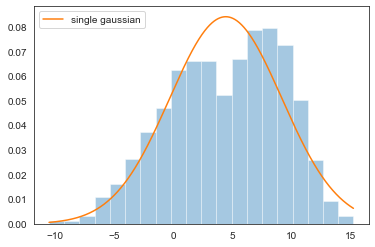

In [8]:
#gaussian of best fit
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))
#fit a single gaussian curve to the data
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True);
plt.plot(x, g_single, label='single gaussian');
plt.legend();

### The code for EM with 2 Gaussian mixture model

In [9]:
class GaussianMixture_self:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=1, sigma_max=1, mix=.5):
        self.data = data
        #todo the Algorithm would be numerical enhanced by normalizing the data first, next do all the EM steps and do the de-normalising at the end
        
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, assign each point to gaussian 1 or 2 with a percentage"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(den) #freshening up self.loglike in the process
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights) 
        one_den = sum(left)
        two_den = sum(rigt)

        # compute new means
        self.one.mu = sum(w * d  for (w, d) in zip(left, data)) / one_den
        self.two.mu = sum(w * d  for (w, d) in zip(rigt, data)) / two_den
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)
        
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)
print("done")

done


### See the algorithm in action

In [10]:
# See the algorithm in action
n_iterations = 20
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture_self(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        print("one less")
        pass

 1 Mixture: Gaussian(10.4262, 1.35499), Gaussian(2.71782, 3.9022), mix=0.225)
 1 Mixture: Gaussian(10.081, 1.48891), Gaussian(2.95547, 4.16199), mix=0.21)
 1 Mixture: Gaussian(9.84667, 1.55112), Gaussian(3.04368, 4.27281), mix=0.207)
 1 Mixture: Gaussian(9.68506, 1.58968), Gaussian(3.07581, 4.32993), mix=0.208)
 1 Mixture: Gaussian(9.57164, 1.6192), Gaussian(3.08179, 4.36107), mix=0.211)
 1 Mixture: Gaussian(9.49054, 1.64471), Gaussian(3.07406, 4.37759), mix=0.214)
 1 Mixture: Gaussian(9.43142, 1.66802), Gaussian(3.0586, 4.38512), mix=0.218)
 1 Mixture: Gaussian(9.38741, 1.68979), Gaussian(3.0386, 4.38682), mix=0.222)
 1 Mixture: Gaussian(9.3539, 1.71024), Gaussian(3.01587, 4.38462), mix=0.226)
 1 Mixture: Gaussian(9.32772, 1.72948), Gaussian(2.99155, 4.37978), mix=0.23)
 1 Mixture: Gaussian(9.3067, 1.7476), Gaussian(2.96634, 4.37313), mix=0.234)
 1 Mixture: Gaussian(9.28933, 1.76467), Gaussian(2.94072, 4.36524), mix=0.238)
 1 Mixture: Gaussian(9.27458, 1.78077), Gaussian(2.91501, 4.35

### Find best Mixture Gaussian model

Computing best model with random restarts...

Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0
Gaussian 1: μ = 8.8, σ = 2.2, weight = 0.38
Gaussian 2: μ = 1.8, σ = 3.8, weight = 0.62


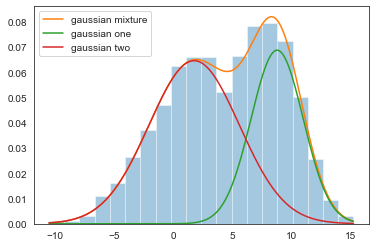

In [11]:
# Find best Mixture Gaussian model
n_iterations = 300
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture_self(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
#print('Best Gaussian Mixture : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))

print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("1", best_mix.one.mu, best_mix.one.sigma, best_mix.mix))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("2", best_mix.two.mu, best_mix.two.sigma, (1-best_mix.mix)))
#Show mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True);
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='gaussian one');
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='gaussian two');
plt.legend();

## Results
The models nicely estimates our own mean entered μ and σ. With this understanding it is not hard to imagine to extend this to n-Gaussians or m-dimensions. You don't need to write complax code since these algorithms have been implemented in some excellent libraries.

### sklearn GaussianMixture
Or we could make use of a library that already has the functionality implemented. The sklearn GaussianMixture object implements the expectation-maximization (EM) algorithm for fitting mixture-of-Gaussian models. A GaussianMixture.fit method is provided that learns a Gaussian Mixture Model from train data. Now you can try yourself with n-Gaussians or m-dimensions.

Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0
Gaussian 1: μ = 1.7, σ = 3.8, weight = 0.61
Gaussian 2: μ = 8.8, σ = 2.2, weight = 0.39


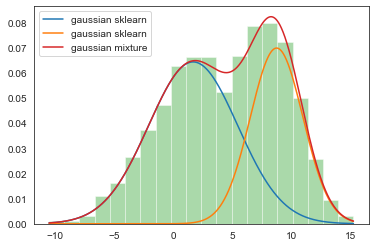

In [13]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 2, tol=0.000001)
gmm.fit(np.expand_dims(data, 1)) # Parameters: array-like, shape (n_samples, n_features), 1 dimension dataset so 1 feature
Gaussian_nr = 1
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
    print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format(Gaussian_nr, mu, sd, p))
    g_s = stats.norm(mu, sd).pdf(x) * p
    plt.plot(x, g_s, label='gaussian sklearn');
    Gaussian_nr += 1
sns.distplot(data, bins=20, kde=False, norm_hist=True)
gmm_sum = np.exp([gmm.score_samples(e.reshape(-1, 1)) for e in x]) #gmm gives log probability, hence the exp() function
plt.plot(x, gmm_sum, label='gaussian mixture');
plt.legend();

GOOD LUCK :)